<a href="https://colab.research.google.com/github/artoowang/ray_tracer_colab/blob/main/Ray_Tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Tracer in Colab

This is a Colab setup to build and run a C++ ray tracer implementation forked from https://raytracing.github.io/. A thin Python/Cython layer is created to run the C++ code, and display the rendered image in the notebook. This allows both the high performance from C++ code and the flexibility of Python/Colab, but at the cost of requiring some Cython code to interface between them.

## Directory structure

The C++ sources are stored in the [`ray_tracer_colab`](https://github.com/artoowang/ray_tracer_colab) repo, and it will be checked out to the working directory of the Colab runtime in the initialization cell below.

When running the Colab runtime locally, it is also possible to manually check out the `ray_tracer_colab` repo under exactly that name. If such directory exists, initialization will use that directory and skip the checking out. This allows changing the C++ code locally (e.g., in a terminal) and rebuild the Cython module in this notebook to pick up the changes, which is useful for development.

## Initialization

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image

%reload_ext Cython

imageio.plugins.freeimage.download()

In [2]:
if os.path.exists('ray_tracer_colab'):
  print('Use local ray_tracer_colab repo.')
else:
  print('Checking out ray_tracer_colab repo ...')
  !git clone https://github.com/artoowang/ray_tracer_colab.git

Use local ray_tracer_colab repo.


In [16]:
# Generate platform dependent cython arguments.
if sys.platform == 'darwin':
  cython_sys_dep_args = [
      '-c=-Wno-unreachable-code',
      '-c=-Wp,-fopenmp',
      '--link-args=-Wp,-fopenmp',
      '--link-args=-lomp',
  ]
else:
  cython_sys_dep_args = [
      '-c=-fopenmp',
      '--link-args=-fopenmp',
  ]

## ray_tracer_colab library

This contains all of the C++ sources for the ray tracer. If the C++ sources are modified, run this cell again to update `libray_tracer_colab.a`.

In [12]:
!g++ -O3 -fPIC -Iray_tracer_colab/include -std=c++17 -c ray_tracer_colab/src/scene.cc -o ray_tracer_colab.o
!ar rcs libray_tracer_colab.a ray_tracer_colab.o

## create_scene.h

In [44]:
%%file create_scene.h

#ifndef CREATE_SCENE_H
#define CREATE_SCENE_H

#include <memory>

#include "hittable.h"
#include "hittable_list.h"

hittable_list CreateRandomWorld();
std::unique_ptr<hittable> CreateSphere();

#endif  // CREATE_SCENE_H

Overwriting create_scene.h


## create_scene.cc

In [45]:
%%file create_scene.cc

#include "create_scene.h"

#include <utility>

#include "color.h"
#include "hittable_list.h"
#include "material.h"
#include "rtweekend.h"
#include "sphere.h"

hittable_list CreateRandomWorld() {
    hittable_list world;

    auto ground_material = make_shared<lambertian>(color(0.5, 0.5, 0.5));
    world.add(std::make_unique<sphere>(point3(0,-1000,0), 1000, ground_material));

    for (int a = -11; a < 11; a++) {
        for (int b = -11; b < 11; b++) {
            auto choose_mat = random_double();
            point3 center(a + 0.9*random_double(), 0.2, b + 0.9*random_double());

            if ((center - point3(4, 0.2, 0)).length() > 0.9) {
                shared_ptr<material> sphere_material;

                if (choose_mat < 0.8) {
                    // diffuse
                    auto albedo = color::random() * color::random();
                    sphere_material = make_shared<lambertian>(albedo);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                } else if (choose_mat < 0.95) {
                    // metal
                    auto albedo = color::random(0.5, 1);
                    auto fuzz = random_double(0, 0.5);
                    sphere_material = make_shared<metal>(albedo, fuzz);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                } else {
                    // glass
                    sphere_material = make_shared<dielectric>(1.5);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                }
            }
        }
    }

    auto material1 = make_shared<dielectric>(1.5);
    world.add(std::make_unique<sphere>(point3(0, 1, 0), 1.0, material1));

    auto material2 = make_shared<lambertian>(color(0.4, 0.2, 0.1));
    world.add(std::make_unique<sphere>(point3(-4, 1, 0), 1.0, material2));

    auto material3 = make_shared<metal>(color(0.7, 0.6, 0.5), 0.0);
    world.add(std::make_unique<sphere>(point3(4, 1, 0), 1.0, material3));

    return world;
}

std::unique_ptr<hittable> CreateSphere() {
  auto material = make_shared<lambertian>(color(0.4, 0.2, 0.1));
  return std::make_unique<sphere>(point3(0, 1, 0), 1.0, material);
}

Overwriting create_scene.cc


## create_scene.pxd

In [46]:
%%file create_scene.pxd

from libcpp.memory cimport unique_ptr

from ray_tracer_colab.pxd.hittable cimport hittable
from ray_tracer_colab.pxd.hittable_list cimport hittable_list

cdef extern from 'create_scene.h':
  hittable_list CreateRandomWorld()
  unique_ptr[hittable] CreateSphere()

Overwriting create_scene.pxd


## Run

[1/1] Cythonizing /Users/cpwang/.ipython/cython/_cython_magic_a6224ce5e50e63afd279978c8bbd1fe5.pyx
building '_cython_magic_a6224ce5e50e63afd279978c8bbd1fe5' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -I/Applications/Xcode_13.1.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include -I/Applications/Xcode_13.1.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include -I. -Iray_tracer_colab/include -I/Users/cpwang/.pyenv/versions/3.9.2/lib/python3.9/site-packages/numpy/core/include -I/Users/cpwang/.pyenv/versions/3.9.2/include/python3.9 -c /Users/cpwang/.ipython/cython/_cython_magic_a6224ce5e50e63afd279978c8bbd1fe5.cpp -o /Users/cpwang/.ipython/cython/Users/cpwang/.ipython/cython/_cython_magic_a6224ce5e50e63afd279978c8bbd1fe5.o -std=c++17 -Wno-unreachable-code -Wp,-fopenmp
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -I/Application

  0%|          | 0/645 [00:00<?, ?it/s]

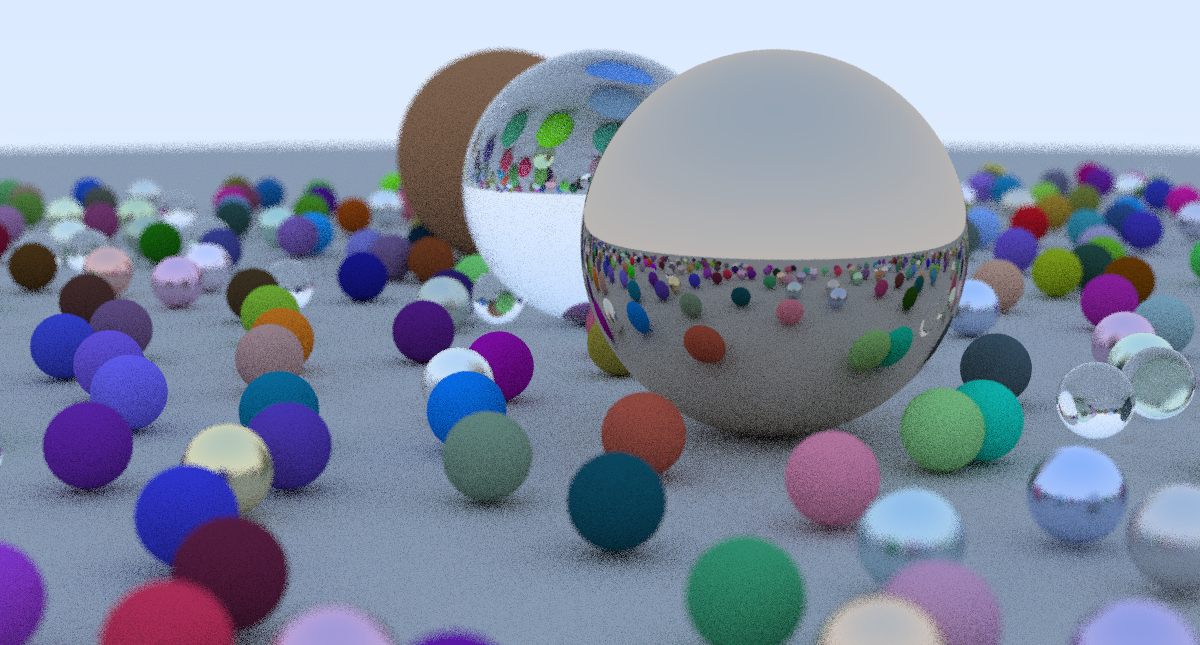

In [47]:
%%cython --verbose -3 -I. -Iray_tracer_colab/include -f -c=-std=c++17 --cplus -S create_scene.cc -L. -lray_tracer_colab {' '.join(cython_sys_dep_args)}

import cython
import numpy as np
import time

from IPython import display
from PIL import Image
from cython.parallel import prange, threadid
from tqdm.notebook import tqdm

from ray_tracer_colab.utils.preview_display import PreviewDisplay

from libc.stdint cimport uint8_t
from libcpp.memory cimport unique_ptr
from libcpp.utility cimport move

from ray_tracer_colab.pxd.camera cimport Camera
from ray_tracer_colab.pxd.hittable cimport hittable
from ray_tracer_colab.pxd.hittable_list cimport hittable_list
from ray_tracer_colab.pxd.scene cimport Scene
from ray_tracer_colab.pxd.vec3 cimport vec3
from create_scene cimport CreateRandomWorld


cdef Scene create_scene(int image_width, int image_height):
  cdef vec3 lookfrom = vec3(13, 2, 3)
  cdef vec3 lookat = vec3(0, 0, 0)
  cdef vec3 vup = vec3(0, 1, 0)
  cdef double vfov_deg = 20.0
  cdef double aperture = 0.1
  cdef double aspect_ratio = image_width / image_height
  cdef double dist_to_focus = 10.0
  cdef Camera camera = Camera(
      lookfrom, lookat, vup, vfov_deg, aspect_ratio, aperture, dist_to_focus,
      0.0, 0.0)
  # TODO: Next is to create the random world in Cython.
  return Scene(image_width, image_height, 10, 50, CreateRandomWorld(),
               move(camera))


def run_parallel(int image_width, int image_height):
  # Create the bytearray to hold the ray tracer output.
  cdef bytearray buffer = bytearray(image_width * image_height * 3)
  # We need to explicitly declare a uint8_t pointer because we cannot access
  # bytearray within prange().
  cdef uint8_t* ptr = buffer
  cdef uint8_t* line

  cdef Py_ssize_t y
  cdef Scene scene = create_scene(image_width, image_height)

  progress_bar = tqdm(total=image_height)
  preview = PreviewDisplay(every_n_sec=10.0, image_width=image_width,
                           image_height=image_height)

  # 'dynamic' schedule allows each thread to pick one line at a time, and thus
  # makes sure all threads will be busy for the entire image.
  for y in prange(image_height, nogil=True, schedule='dynamic'):
    with gil:
      progress_bar.update(1)
      preview.maybe_update(buffer)
    # The row 0 in a PIL Image buffer is at the top, while in our image space
    # y = 0 is the bottom row, so we flip it here to find the pointer to the
    # correct output line.
    line = ptr + (image_height - y - 1) * image_width * 3
    scene.RenderLine(y, line)

  # Final update to progress bar and preview image.
  progress_bar.close()
  preview.update(buffer)
  return preview.get_image()

run_parallel(1200, 645)
#run_parallel(240, 180)
#print(test(240, 180))

## Reload local modules

This is needed to reload the modified Python modules from the local directory.

In [ ]:
from importlib import reload
import utils.preview_display
reload(utils.preview_display)